In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict,Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import json
from langchain_groq import ChatGroq

In [2]:
load_dotenv()

True

In [3]:
class SentimentSchema(BaseModel):
  sentiment: Literal['positive','negative'] = Field(..., description="The sentiment of the review")

In [4]:
class DiagnosisSchema(BaseModel):
  issues_type: Literal['UX','Performance','Bug','Support','Other'] = Field(..., description="The type of issue identified in the review")
  tone: Literal['Angry','Frustrated','Confused','Neutral','Happy'] = Field(..., description="The tone of the review")
  urgency: Literal['Low','Medium','High'] = Field(..., description="The urgency level of the issue described in the review")


In [5]:
class ReviewState(TypedDict):
  review: str
  sentiment:  Literal['positive','negative']
  diagnosis: dict
  response: str

In [6]:
model = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0
)

In [24]:


# def analyze_sentiment(state: ReviewState) -> SentimentSchema:
#     prompt = f"""
# You are a sentiment classifier.

# Return ONLY valid JSON in this exact format:
# {{"sentiment": "positive" | "negative" }}

# Review:
# {state["review"]}
# """

#     response = model.invoke(prompt)

#     # Parse manually (LangGraph style)
#     data = json.loads(response.content)

#     # Optional: validate with Pydantic
#     parsed = SentimentSchema(**data)

#     return {
#         "sentiment": parsed.sentiment
#     }
structure_model = model.with_structured_output(SentimentSchema)
dignosis_model = model.with_structured_output(DiagnosisSchema)


In [ ]:


def analyze_sentiment(state: ReviewState) -> SentimentSchema:
    prompt = f"""
You are a sentiment classifier.


Review:
{state["review"]}
"""

    response = structure_model.invoke(prompt)


    return {
        "sentiment": response.sentiment
    }

In [36]:
def check_sentiment(state: ReviewState) -> Literal['run_diagnosis',
'positive_response']:
    if state['sentiment'] == 'positive':
        return 'positive_response' 
    return 'run_diagnosis'
def positive_response(state: ReviewState) :
    prompt = f""" write a short thank you message to a customer who left a positive review: {state['review']}
    kindly ask user to leave a review on our website."""
    response = model.invoke(prompt)
    
    return {'response': response.content}
def run_diagnosis(state: ReviewState) :
    prompt = f""" analyze the following negative review and provide a diagnosis of the issue: {state['review']}
    provide suggestions on how to improve the product or service based on the review."""
    response = dignosis_model.invoke(prompt)
    
    return {'diagnosis': response.model_dump()}
def negative_response(state: ReviewState) :
    prompt = f""" user left the following negative review: {state['review']} having following issue type : {state['diagnosis']['issues_type']}, tone: {state['diagnosis']['tone']}, urgency: {state['diagnosis']['urgency']}
    write a empathetic response addressing the customer's concerns and offering assistance or solutions."""
    response = model.invoke(prompt)
    
    return {'response': response.content}


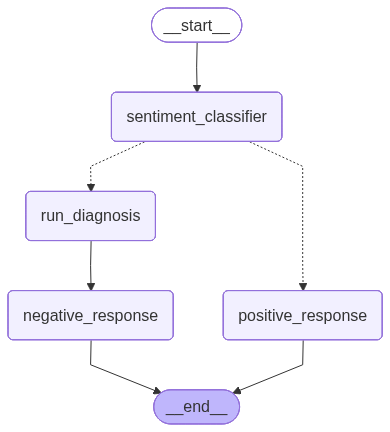

In [38]:
graph = StateGraph(ReviewState)

graph.add_node('sentiment_classifier', analyze_sentiment)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('positive_response',positive_response)
graph.add_node('negative_response',negative_response)

graph.add_edge(START, 'sentiment_classifier')
graph.add_conditional_edges('sentiment_classifier', check_sentiment)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('positive_response', END)
graph.add_edge('negative_response', END)
workflow = graph.compile()
workflow

In [41]:
inital_state = {
    "review": "i have a problem with the product i bought last week. it stopped working after two days of use. im really disappointed because i expected better quality for the price i paid. please help me resolve this issue as soon as possible.",
}
workflow.invoke(inital_state)

{'review': 'i have a problem with the product i bought last week. it stopped working after two days of use. im really disappointed because i expected better quality for the price i paid. please help me resolve this issue as soon as possible.',
 'sentiment': 'negative',
 'diagnosis': {'issues_type': 'Bug', 'tone': 'Angry', 'urgency': 'High'},
 'response': "Dear valued customer,\n\nI'm so sorry to hear that the product you purchased from us stopped working after just two days of use. I can imagine how frustrating and disappointing this must be, especially considering the price you paid. I want to assure you that we take all complaints seriously and are committed to making things right.\n\nI'd like to start by apologizing for the inconvenience this has caused you. We understand that our product failed to meet your expectations, and for that, we're truly sorry. I'd like to offer my assistance in resolving this issue as quickly as possible.\n\nTo better understand the problem, could you ple